## Learning outcomes

We will be focusing on image segmentation algorithms:

 - k-means clustering
 - anisotropic segmentation
 - watershed segmentation

## Setup

In [1]:
! pip install requests

In [2]:
import sys
assert sys.version_info >= (3, 7)

import numpy as np
import cv2 as cv
from util_func import *

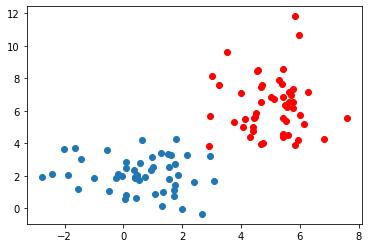

In [3]:
# to get consistent result
np.random.seed(2)

# define bivariate Gaussian distribution function and sample
mean1 = (1, 2)
cov1 = np.array([[2, 0], [0, 1]])
dat1 = np.random.multivariate_normal(mean1, cov1, size = 50)

# cluster2
mean2 = (5, 6)
cov2 = np.array([[1, 0],[0, 2]])
dat2 = np.random.multivariate_normal(mean2, cov2, size=50)

# concatenate dat1 and dat2 into 1 array
data = np.concatenate((dat1, dat2), axis = 0)

plt.scatter(dat1[:, 0], dat1[:, 1])
plt.scatter(dat2[:, 0], dat2[:, 1], c="r")
plt.show()

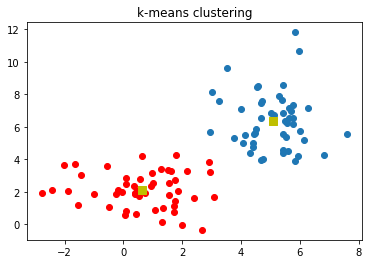

In [4]:
# kmeans clustering : sklearn, cv
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)

# input data should be float32
Z = np.float32(data)
ret, label, center = cv.kmeans(Z, 2, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

# subset the data with label 0 and 1
A = Z[label.ravel() == 0]
B = Z[label.ravel() == 1]

plt.scatter(A[:, 0], A[:, 1])
plt.scatter(B[:, 0], B[:, 1], c="r")
plt.scatter(center[:, 0], center[:, 1], c="y", s=80, marker = "s")
plt.title("k-means clustering")
plt.show()

In [5]:
np.unique(label)

array([0, 1], dtype=int32)

In [6]:
label.shape

(100, 1)

### Demo of color image (k-means clustering)

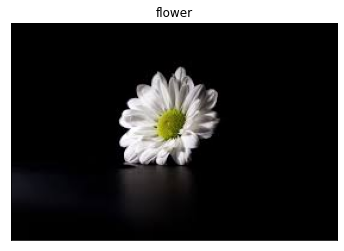

In [7]:
img = cv.imread("images/flower.jfif")
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt_img(img_rgb, "flower")

In [8]:
def k_means_clust(img, K, max_iter=10, eps=1.0, attempts = 10, flag=cv.KMEANS_PP_CENTERS):
    """Args
    img: color image (3 channel)
    K = number of clusters
    By default, max_iter=10, eps=1, atempts=10, k-means++"""
    img = img.reshape((-1, 3))
    img = np.float32(img)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, max_iter, eps)
    return cv.kmeans(img, K, None, criteria, attempts, flag)

ret, label, center = k_means_clust(img_rgb, 3)

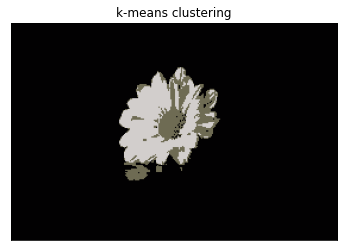

In [9]:
# propagate center back into the image
center = np.uint8(center)

res = center[label.flatten()]
quant = res.reshape(img_rgb.shape)

plt_img(quant, "k-means clustering")

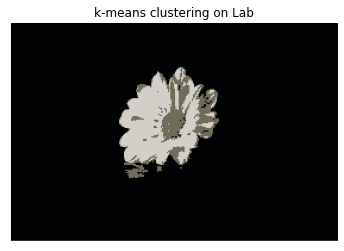

In [10]:
# lab because of perceptual uniformity

img = cv.imread("images/flower.jfif")
img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)

ret, label, center = k_means_clust(img_lab, 3)

center = np.uint8(center)

res = center[label.flatten()]
quant = res.reshape(img_lab.shape)

# change from lab to rgb
quant_rgb = cv.cvtColor(quant, cv.COLOR_Lab2RGB)

plt_img(quant_rgb, "k-means clustering on Lab")

## Anisotropic segmentation

In [11]:
def calcGST(inputIMG, w, method_edge="scharr"):
    img = np.float32(inputIMG)
    
    # Gradient structure tensor components
    if method_edge == "scharr":
        imgDiffX = cv.Scharr(img, cv.CV_32F, 1, 0)
        imgDiffY = cv.Scharr(img, cv.CV_32F, 0, 1)
    elif method_edge == "sobel":
        imgDiffX = cv.Sobel(img, cv.CV_32F, 1, 0)
        imgDiffY = cv.Sobel(img, cv.CV_32F, 0, 1)
        
    else:
        raise Exception("no edge detection method available")
    imgDiffXY = cv.multiply(imgDiffX, imgDiffY)
    imgDiffXX = cv.multiply(imgDiffX, imgDiffX)
    imgDiffYY = cv.multiply(imgDiffY, imgDiffY)
    
    J11 = cv.boxFilter(imgDiffXX, cv.CV_32F, (w, w))
    J22 = cv.boxFilter(imgDiffYY, cv.CV_32F, (w, w))
    J12 = cv.boxFilter(imgDiffXY, cv.CV_32F, (w, w))
    
    # eigenvalue
    tmp1 = J11+J22
    tmp2 = J11-J22
    tmp2 = cv.multiply(tmp2, tmp2)
    tmp3 = cv.multiply(J12, J12)
    tmp4 = np.sqrt(tmp2 + 4.0*tmp3)
    
    lambda1 = 0.5*(tmp1+tmp4)
    lambda2 = 0.5*(tmp1 - tmp4)
    
    # coherency
    imgCoherencyOut = cv.divide(lambda1-lambda2, lambda1+lambda2)
    
    # orientation calculation
    imgOrientationOut = cv.phase(J22-J11, 2.0*J12, angleInDegrees = True)
    imgOrientationOut = 0.5*imgOrientationOut
    
    return imgCoherencyOut, imgOrientationOut

You can use `cv.Gaussion` in line 18-20, instead of `cv.bowFilter()`. But you have to keep in mind of the zero division problem in line 36. Add sall constant on denominator.

(<AxesSubplot:title={'center':'Orientation'}>, None)

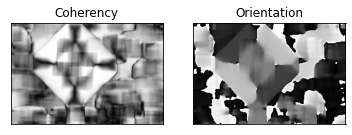

In [12]:
# visual the coherency and orientation map
img = cv.imread("images/traffic_sign.jfif")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
blur = cv.GaussianBlur(gray, (5, 5), 0)

W = 25
imgCoherency, imgOrientation = calcGST(blur, W)

# normalize coherency and orientation
imgCoherency_norm = cv.normalize(imgCoherency, None, alpha=0, beta=1, 
                                norm_type = cv.NORM_MINMAX, dtype=cv.CV_32F)

imgOrientation_norm = cv.normalize(imgOrientation, None, alpha=0, beta=1, 
                                norm_type = cv.NORM_MINMAX, dtype=cv.CV_32F)

plt.subplot(121), plt_img(imgCoherency_norm, "Coherency")
plt.subplot(122), plt_img(imgOrientation_norm, "Orientation")

In [13]:
# set up trackbars that control thresholds for coherency and orientation map
def nothing(x):
    pass

wn = "Anisotropic segmentation"
cv.namedWindow(wn, cv.WINDOW_NORMAL | cv.WINDOW_FREERATIO)
cv.createTrackbar("Coherency threshold 1", wn, 50, 100, nothing)
cv.createTrackbar("Coherency threshold 2", wn, 70, 100, nothing)
cv.createTrackbar("Orientation threshold 1", wn, 50, 180, nothing)
cv.createTrackbar("Orientation threshold 2", wn, 100, 180, nothing)

img = cv.imread("images/traffic_sign.jfif")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
blur = cv.GaussianBlur(gray, (5, 5), 0)

# Computation of GST
W = 27
imgCoherency, imgOrientation = calcGST(blur, W)

while (1):
    th_C_1 = cv.getTrackbarPos("Coherency threshold 1", wn) * 0.01
    th_C_2 = cv.getTrackbarPos("Coherency threshold 2", wn) * 0.01
    th_Or_1 = cv.getTrackbarPos("Orientation threshold 1", wn)
    th_Or_2 = cv.getTrackbarPos("Orientation threshold 2", wn)
    
    # Perform thresholding
    imgBin_C_1 = cv.threshold(imgCoherency, th_C_1, 255, cv.THRESH_BINARY)[1]
    imgBin_C_2 = cv.threshold(imgCoherency, th_C_2, 255, cv.THRESH_BINARY_INV)[1]
    imgBin_Or_1 = cv.threshold(imgOrientation, th_Or_1, 255, cv.THRESH_BINARY)[1]
    imgBin_Or_2 = cv.threshold(imgOrientation, th_Or_2, 255, cv.THRESH_BINARY_INV)[1]

    # merge the pairs of coherency binary and orientation binary
    imgBin_C = cv.bitwise_and(imgBin_C_1, imgBin_C_2)
    imgBin_Or = cv.bitwise_and(imgBin_Or_1, imgBin_Or_2)
    
    # final mask
    imgBin = cv.bitwise_and(imgBin_C, imgBin_Or)
    
    # print the segmentation result
    mask = imgBin != 0
    res = img*(mask[:, :, None].astype(np.uint8))
    cv.imshow(wn, res)
    cv.imshow("segmentation mask", imgBin)
    
    k = cv.waitKey(1) & 0xFF
    if k==27:
        break
        
cv.destroyAllWindows()

## Watershed segmentation on traffic sign images

In [ ]:
img = cv.imread("images/traffic_sign.jfif")

show_img("img", img)

In [ ]:
# gaussian blurring
blur = cv.GaussianBlur(img, (5, 5), 0)

# mean shift segmentation
blur = cv.pyrMeanShiftFiltering(blur, 15, 20, maxLevel = 2)

show_img("mean shift", blur)

In [ ]:
# grayscale
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

# morphological gradient (edge, local maximun)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (11, 11))
loc_grad = cv.morphologyEx(gray, cv.MORPH_GRADIENT, kernel, iterations = 2)

show_img("gradient", loc_grad)

In [ ]:
!pip install scikit-image

In [ ]:
# import libraries
from scipy import ndimage as ndi    # label marker (boolean)
from skimage.segmentation import watershed

In [ ]:
# th
th = loc_grad < 80   # boolean
s = np.ones((3, 3), dtype=int)
marker = ndi.label(th, structure = s)[0]

plt.imshow(marker, cmap = "jet")
plt.show()

In [ ]:
# topographic surface 
edge = cv.Canny(gray, 250, 500)

labels = watershed(edge, marker)

np.unique(labels, return_counts = True)

In [ ]:
plt.figure()

gray_ori = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.imshow(gray_ori, cmap = "gray")
plt.imshow(labels, cmap = plt.cm.nipy_spectral, alpha = 0.5)
plt.show()

In [ ]:
# remove background. assumption : background has larger area
label_vec, counts = np.unique(labels,return_counts = True)

label_bg = label_vec[np.argmax(counts)]

mask = 255*np.ones(labels.shape, dtype=np.uint8)

mask[labels==label_bg] = 0

# find contour
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# find the largest contour
contour = sorted(contours, key = cv.contourArea, reverse = True)[0]

img_copy = img.copy()
cv.drawContours(img_copy, [contour], -1, (0, 255,0), 2)

show_img("watersjed", img_copy)

In [ ]:
label_bg

### Image 2

In [ ]:
img = cv.imread("images/traffic_sign1.jpg")
(h, w) = img.shape[:2]
blur = cv.GaussianBlur(img, (5, 5), 0)

In [ ]:
# Convert to Lab
img_lab = cv.cvtColor(blur, cv.COLOR_BGR2Lab)
img_lab = img_lab.reshape((h*w, 3))
img_lab = np.float32(img_lab)
# criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv.KMEANS_PP_CENTERS
compactness, labels, centers = cv.kmeans(img_lab, 10, None, criteria, 10, flags)
quant = centers.astype(np.uint8)[labels]
quant = quant.reshape((h, w, 3))
bgr = cv.cvtColor(quant, cv.COLOR_Lab2BGR)
show_img("kmeans quantization", bgr)


In [ ]:
img_lab[..., 0].min()

In [ ]:
gray = cv.cvtColor(bgr, cv.COLOR_BGR2GRAY)
th = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
show_img("threshold", th)


In [ ]:
!pip install scikit-image

In [ ]:

kernel = np.ones((3, 3), dtype=np.uint8)
th = cv.morphologyEx(th, cv.MORPH_OPEN, kernel, iterations=3)
dist_transform = cv.distanceTransform(th, cv.DIST_L2, 3)
coords = peak_local_max(dist_transform, footprint=np.ones((100, 100)), labels=th)
mask = np.zeros(dist_transform.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-dist_transform, markers, mask=th)


In [ ]:
plt.imshow(labels, cmap=plt.cm.jet)
plt.colorbar(), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
# remove background. assumption : background has larger area
label_vec, counts = np.unique(labels,return_counts = True)

label_bg = label_vec[np.argmax(counts)]

mask = 255*np.ones(labels.shape, dtype=np.uint8)

mask[labels==label_bg] = 0

# find contour
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# find the largest contour
contour = sorted(contours, key = cv.contourArea, reverse = True)[0]

img_copy = img.copy()
cv.drawContours(img_copy, [contour], -1, (0, 255,0), 2)

show_img("watershed", img_copy)

In [ ]:
x, y, w, h = cv.boundingRect(contour)
cv.rectangle(img_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)

show_img("bounding box", img_copy)

## Weekly activity

### Exercise 1

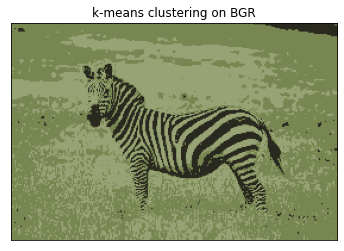

In [14]:
img = cv.imread("images/zebra.jfif")
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt_img(img_rgb, "zebra")

ret, label, center = k_means_clust(img_rgb, 3)

center = np.uint8(center)
 
res = center[label.flatten()]
quant = res.reshape(img_rgb.shape)

plt_img(quant, "k-means clustering on BGR")

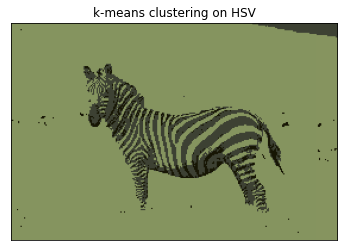

In [15]:

img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

ret, label, center = k_means_clust(img_hsv, 3)

center = np.uint8(center)

res = center[label.flatten()]
quant = res.reshape(img_hsv.shape)

# HSV to RGB
quant_rgb = cv.cvtColor(quant, cv.COLOR_HSV2RGB)

plt_img(quant_rgb, "k-means clustering on HSV")

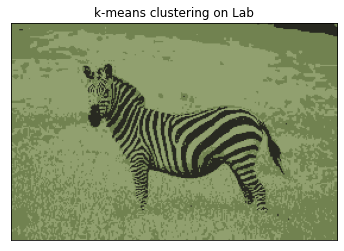

In [16]:
img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)

ret, label, center = k_means_clust(img_lab, 3)

center = np.uint8(center)

res = center[label.flatten()]
quant = res.reshape(img_lab.shape)

# Lab to RGB
quant_rgb = cv.cvtColor(quant, cv.COLOR_Lab2RGB)

plt_img(quant_rgb, "k-means clustering on Lab")

Lab is the most suitable method because the image look cleaner